# Convert model TFlite

In [1]:
!echo $(pwd)

/home/philong/Desktop/deeplearning/tensorflow


In [36]:
from tensorflow.python.tools import freeze_graph
import sys
sys.path.append('/home/philong/Desktop/deeplearning/tensorflow/models/research/object_detection/')
import export_tflite_ssd_graph

In [37]:
!python ./models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path=/home/philong/Desktop/deeplearning/tensorflow/model_save/pipeline.config \
--trained_checkpoint_prefix=/home/philong/Desktop/deeplearning/tensorflow/model_save/model.ckpt \
--output_directory=./model_TFlite/food_model_frozen \
--add_postprocessing_op = True

W0903 17:19:24.469475 140254071084800 deprecation_wrapper.py:119] From /home/philong/Desktop/deeplearning/tensorflow/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0903 17:19:24.479114 140254071084800 deprecation_wrapper.py:119] From /home/philong/Desktop/deeplearning/tensorflow/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0903 17:19:24.488541 140254071084800 deprecation_wrapper.py:119] From ./models/research/object_detection/export_tflite_ssd_graph.py:143: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0903 17:19:24.489177 140254071084800 deprecation_wrapper.py:119] From ./models/research/object_detection/export_tflite_ssd_graph.py:133: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0903 17:19:24.494072 140254071084800 deprecation_wrapper.py:119] Fro

In [38]:
frozen_graph_dir = './model_TFlite/food_model_frozen/tflite_graph.pb'

In [39]:
import tensorflow as tf

graph_def_file = frozen_graph_dir

input_shapes = {"normalized_input_image_tensor" : [1, 300, 300, 3]}
input_arrays = ['normalized_input_image_tensor']
output_arrays = ['TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3']

converter = tf.lite.TFLiteConverter.from_frozen_graph(graph_def_file,input_arrays, output_arrays,input_shapes)
#---------------------------------------------------------------
#converter.inference_input_type = tf.lite.constants.QUANTIZED_UINT8
#converter.inference_type = tf.lite.constants.QUANTIZED_UINT8
# converter.default_ranges_stats = (0,255)
# converter.quantized_input_stats = {input_arrays[0] : (127.5,127.5)}  # mean, std_dev
# converter.reorder_across_fake_quant = True
#converter.post_training_quantize = True
#------------------------------------------------------------------z
converter.allow_custom_ops=True

tflite_model = converter.convert()

In [40]:
tflite_path = './model_TFlite/food_model_frozen/food_detection.tflite'
open(tflite_path, "wb").write(tflite_model)

22079736

# Tensorflow Interpreter 

In [41]:
import numpy as np
import tensorflow as tf
from PIL import Image

In [122]:
#tflite_path ='./data/model_tflite_khang/detect.tflite'
#---------------------------------------------------
img_dir = '/home/philong/Desktop/tf_serving/food/17.jpg'


In [123]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# # NxHxWxC, H:1, W:2
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]
image = Image.open(img_dir)
img_resize = image.resize((width, height))
frame = np.expand_dims(img_resize, axis=0)
frame = np.float32((frame - 128)) / 128 
#frame =  ( 2*frame)/256 -1
frame = frame.astype('float32')
#---------------------------------------------------
interpreter.set_tensor(input_details[0]['index'], frame)
interpreter.invoke()

boxes = interpreter.get_tensor(output_details[0]['index'])
classes = interpreter.get_tensor(output_details[1]['index'])
scores = interpreter.get_tensor(output_details[2]['index'])
num_box = interpreter.get_tensor(output_details[3]['index'])

print(num_box)

[2.]


# Display result

In [124]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

(2208, 1242, 3)
0
[ 202.95388913  574.80599749  710.73765278 1188.63658798]
1
[ 424.47506618   47.5440318  1194.36535263  700.55330658]


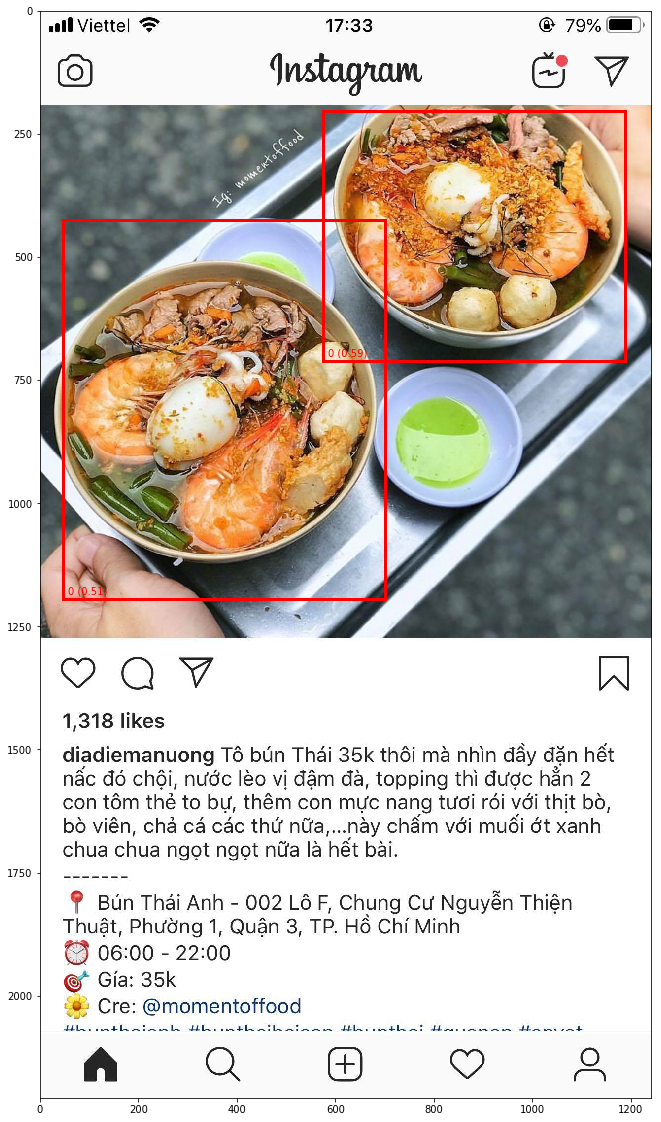

In [125]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1)
#plt.imshow(image)
image = np.array(image)

print(image.shape)
ax.imshow(image)
scales_h = image.shape[0]
scales_w = image.shape[1]

for i in range(int(num_box)):
    print(i)
    box = boxes[0][i] * np.array([scales_h,scales_w,scales_h,scales_w])
    print(box)
    # display rectangle
    if scores[0][i] > 0.0:
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0] ,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(patch) 
        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[0][i], scores[0][i]), color='r')
    else:
        patch = patches.Rectangle((box[1], box[0]), box[3] - box[1], box[2] - box[0] ,linewidth=2,edgecolor='w',facecolor='none')
        ax.add_patch(patch) 
        # display class index and score
        plt.text(x=box[1] + 10, y=box[2] - 10, s='%d (%0.2f) ' % (classes[0][i], scores[0][i]), color='g')